# ML'S CUP
In questo notebook ci occupiamo di analizzare i modelli per il task della ML's Cup. Si tratta di un problema di regressione con tre output. Per prima cosa, importiamo le librerie che ci serviranno nel corso della nostra indagine e carichiamo il dataset

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
columns = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8",
           "x9", "x10", "x11", "x12", "y1", "y2", "y3"]

df = pd.read_csv('/content/drive/MyDrive/ML-CUP24-TR.csv',
                 usecols=[*range(1, 16)],
                 skiprows=[*range(7)],
                 names=columns)

X_train = df.iloc[:, :12]
y_train = df.iloc[:, 12:]

Dopo aver caricato il dataset di train e averlo diviso in X e Y, ci preoccupiamo di convertire i due dataset X_train e y_train in array attraverso numpy, e standardizziamo le feature in X per poterle utilizzare nel training di alcuni dei modelli successivi. Lo stesso facciamo per il testset, nel quale però non disponiamo dei true output.

In [3]:
# conversione in array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# standardizzazione di X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# caricamento di X_test e standardizzazione
X_test = df = pd.read_csv('/content/drive/MyDrive/ML-CUP24-TS.csv',
                 usecols=[*range(1, 13)],
                 skiprows=[*range(7)],
                 names=columns[:12])

X_test = X_test.to_numpy()

X_test_scaled = scaler.transform(X_test)

A questo punto abbiamo tutto quello che ci serve per poter addestrare il modello. Tuttavia, dal momento che il modello sarà valutata sul Mean Euclidean Error, creiamo una funzione mee() che prenda in input i valori di y true e i valori di y predetti dal nostro modello e restituisca la distanza euclidea media.

In [4]:
def mee(y_true, y_pred):
  return np.mean(np.linalg.norm(y_pred-y_true, axis=1))

Inoltre, non disponendo di un modello baseline per il nostro task, ne costruiamo uno immaginando un dummy regressor che predica sempre il punto medio per ciascuno dei tre output. Quindi, calcoliamo qual è il mee per questo modello sul trainset.

In [6]:
# immagino un modello che predica sempre il punto medio per le tre dimensioni
mean_y1 = np.mean(y_train[:, 0])
mean_y2 = np.mean(y_train[:, 1])
mean_y3 = np.mean(y_train[:, 2])

baseline = np.tile(np.array([mean_y1, mean_y2, mean_y3]), (len(y_train), 1))
mee_baseline = mee(y_train, baseline)

print(f'La Mean Euclidean Distance per il modello baseline è {np.round(mee_baseline, 4)}')

La Mean Euclidean Distance per il modello baseline è 8.908


I nostri modelli, per poter essere accetati, devono riuscire a performare con un Mean Euclidean Error inferiore a 8,908. Ora possiamo procedere con la valutazione dei nostri modelli.

# NEURAL NETWORK CON TENSORFLOW
In questa sezione, ci occupiamo di creare un Neural Network per il task della ML's Cup. Innanzitutto, creiamo una funzione mee_tf() che calcoli il Mean Euclidean Error usando la libreria tensorflow, in modo che sia ottimizzato per il calcolo con i tensori.

In [9]:
def mee_tf(y_true, y_pred):
  return tf.math.reduce_mean(tf.norm(y_pred-y_true, axis=1))

Quindi, creiamo una funzione grid_search_NN() per rendere più leggibile e strutturato il codice durante la grid_search sulla Neural Network. Questa funzione si occupa di inizializzare diversi modelli secondo i parametri passati attraverso l'argomento *model*.  
*model* è una lista di dizionari all'interno del quale ogni dizionario rappresenta una rete neurale. I parametri che si possono passare al dizionario sono gli stessi che si possono inserire in un oggetto Model della libreria di tensorflow. L'accortezza sta nell'inserire il nome del parametro così come sarebbe l'argomento da passare al modello.  
All'interno di *model* va passata la chiave *layers* cui è associata un'altra lista di dizionari. Ogni dizionario di questa lista rappresenta un layer del modello. Come per prima, anche qui i parametri che si possono passare a ogni dizionario sono gli stessi che si possono inserire in un oggetto Layer della libreria tensorflow.  
Gli altri argomenti della funzione servono per passare i dati di train (*X_train* e *y_train*). L'argomento *silent* può essere posto a False se si vuole visualizzare a schermo la tabella stampata dal metodo .summary() di tensorflow. Di default è posto a True.  
Al termine del fit di ciascun modello viene stampata la loss (calcolata con il MSE) e il MEE del modello.  
Al termine della Grid Search è invece visualizzata a schermo l'andamento del training sulla loss e sul MEE per tutti i modelli  

In [13]:
def _get_validation_kwargs(X_VAL, Y_VAL):
  validation_options = {
        True: {'validation_split': 0.2},
        False: {'validation_data': (X_VAL, Y_VAL)}
    }
  return validation_options[X_VAL is None or Y_VAL is None]


def grid_search_NN(X_train, y_train, models=[], silent=True):
  # ottengo le dimensioni per il numero di neuroni in input e in output, che non variano al variare dei modelli
  INPUT_SHAPE = len(X_train[0])
  OUTPUT_SHAPE = len(y_train[0])

  # preparo la lista dove memorizzare le history di ogni modello per mostrarle alla fine
  NUMERO_MODELLI = len(models)
  fig = plt.figure(figsize=(10,8))
  plt.subplots_adjust(hspace=0.35, wspace=0.3)

  # addestro i singoli modelli
  for i, model in enumerate(models):
    # ottengo tutte le caratteristiche del modello
    MODEL_NAME = f'MODELLO {i+1}'

    KERNEL = model.get('kernel', 'glorot_uniform')
    ACTIVATION = model.get('activation', 'relu')
    N_LAYERS = len(model['layers'])

    OPTIMIZER = model.get('optimizer', 'SGD')
    LEARNING_RATE = model.get('learning_rate', 0.01)
    MOMENTUM = model.get('momentum', 0.0)
    NESTOROV = model.get('nesterov', False)

    EPOCHS = model.get('epochs', 10)
    BATCH_SIZE =model.get('batch_size', 32)
    X_VAL = model.get('x_val', None)
    Y_VAL = model.get('y_val', None)

    print(f'{MODEL_NAME}')
    print(f'Parametri dei layers: kernel-->{KERNEL}, activation-->{ACTIVATION}, numero di hidden layers-->{N_LAYERS}')
    print(f'Parametri del modello: optimizer-->{OPTIMIZER}, learning_rate-->{LEARNING_RATE}, momentum-->{MOMENTUM}, nesterov-->{NESTOROV}')
    print(f"Parametri dell'addestramento: epochs-->{EPOCHS}, batch_size-->{BATCH_SIZE}")
    # creo l'architettura del modello
    inputs = tf.keras.Input(shape=(INPUT_SHAPE,))
    h = inputs
    for layer in model['layers']:
      UNITS = layer['units']
      h = tf.keras.layers.Dense(units=UNITS, activation=ACTIVATION, kernel_initializer=KERNEL)(h)
    outputs = tf.keras.layers.Dense(units=OUTPUT_SHAPE, kernel_initializer=KERNEL)(h)

    # inizializzo il modello
    MODELLO = tf.keras.Model(inputs=inputs, outputs=outputs)
    silent or MODELLO.summary()

    # eseguo il compiling del modello
    MODELLO.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE,
                                          momentum=MOMENTUM,
                                          nesterov=NESTOROV),
        loss='mse',
        metrics=[mee_tf]
    )

    # addestro il modello sui dati di train
    validation_kwargs = _get_validation_kwargs(X_VAL, Y_VAL)

    hist = MODELLO.fit(
        X_train, y_train,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose=0, shuffle=True, **validation_kwargs)

    # ottengo la loss e la mee per l'ultima epoca sul validation set per un rapido confronto
    last_loss = hist.history['val_loss'][-1]
    last_mee = hist.history['val_mee_tf'][-1]
    print(f'{MODEL_NAME} addestrato! Loss: {np.round(last_loss, 4)}, MEE: {np.round(last_mee, 4)}\n')

    history = hist.history
    ax = fig.add_subplot(NUMERO_MODELLI, 2, (i*2)+1)
    plt.plot(history['loss'], lw=4)
    plt.plot(history['val_loss'], lw=4)
    plt.legend(['loss', 'val_loss'], fontsize=15)
    ax.set_xlabel('Epochs', fontsize=15)
    plt.title(MODEL_NAME)

    ax = fig.add_subplot(NUMERO_MODELLI, 2, (i*2)+2)
    plt.plot(history['mee_tf'], lw=4)
    plt.plot(history['val_mee_tf'], lw=4)
    plt.legend(['mee', 'val_mee_tf'], fontsize=15)
    ax.set_xlabel('Epochs', fontsize=15)
    plt.title(MODEL_NAME)

Possiamo quindi ora iniziare la nostra grid search. Impostiamo un seed per mantenere i risultati sempre comparabili.  
All'inizio, concentriamo la nostra gridsearch sul numero di layer e sul learning rate, su solo 10 epoche per essere più veloci.

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->2
Parametri del modello: optimizer-->SGD, learning_rate-->0.1, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 13.6767, MEE: 5.1785

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->2
Parametri del modello: optimizer-->SGD, learning_rate-->0.01, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 1.548, MEE: 1.8136

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->2
Parametri del modello: optimizer-->SGD, learning_rate-->0.001, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: 50.5323, MEE: 11.0471

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, n

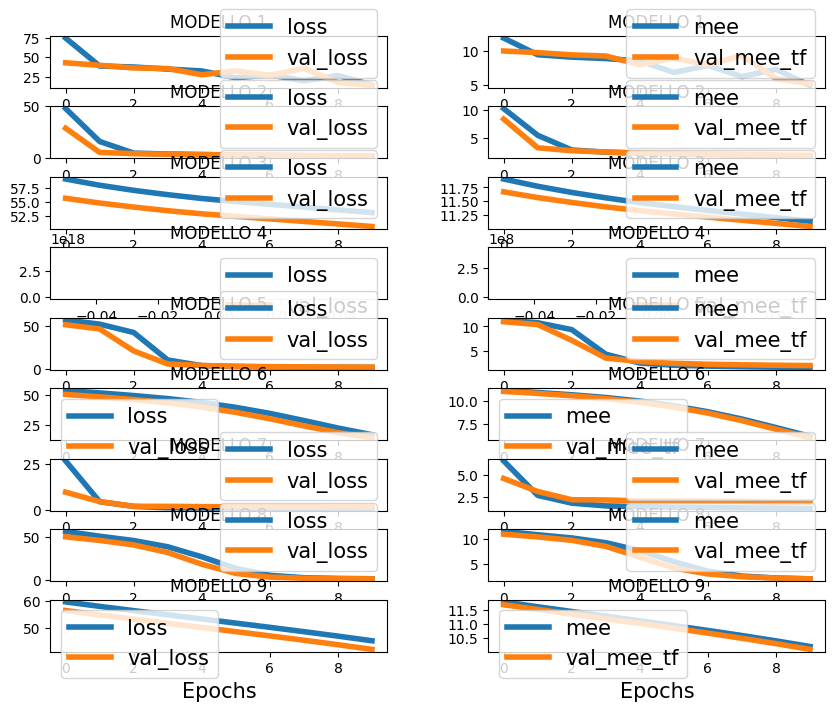

In [14]:
tf.random.set_seed(42)

GS_NN_1 = [
    { # MODELLO 1
        'layers': [
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.1},

    { # MODELLO 2
        'layers': [
            {'units': 16},
            {'units': 8}],
        'learning_rate':0.01},

    { # MODELLO 3
        'layers': [
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.001},

    { # MODELLO 4
        'layers': [
            {'units': 32},
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.1},

    { # MODELLO 5
        'layers': [
            {'units': 32},
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.01},

    { # MODELLO 6
        'layers': [
            {'units': 32},
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.001},

    { # MODELLO 7
        'layers': [
            {'units': 8}],
        'learning_rate': 0.1},

    { # MODELLO 8
        'layers': [
            {'units': 8}],
        'learning_rate': 0.01},

    { # MODELLO 9
        'layers': [
            {'units': 8}],
        'learning_rate': 0.001}]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_1)

I modelli che ottengono risultati soddisfacenti sono i modelli 1, 5, 7, 8. Si capisce, quindi, che un learning rate troppo basso (vicino a 0.001 o inferiore) è sempre pessimo. Inoltre, i modelli con più hidden layer performano bene solo con un learning rate vicino a 0.01. Il modello con un solo hidden layer, tuttavia, sembra più promettente.  
Ora procediamo cercando learning rate migliori per le combinazioni di iperparametri che abbiamo trovato. Inoltre, proviamo un modello in cui le dimensioni degli hidden layer sono minori vicino all'input e maggiori vicino all'output.

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->2
Parametri del modello: optimizer-->SGD, learning_rate-->0.03, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 2.6002, MEE: 2.2773

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->2
Parametri del modello: optimizer-->SGD, learning_rate-->0.007, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 2.6908, MEE: 2.4948

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->3
Parametri del modello: optimizer-->SGD, learning_rate-->0.03, momentum-->0.0, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: 6.2626, MEE: 3.613

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, num

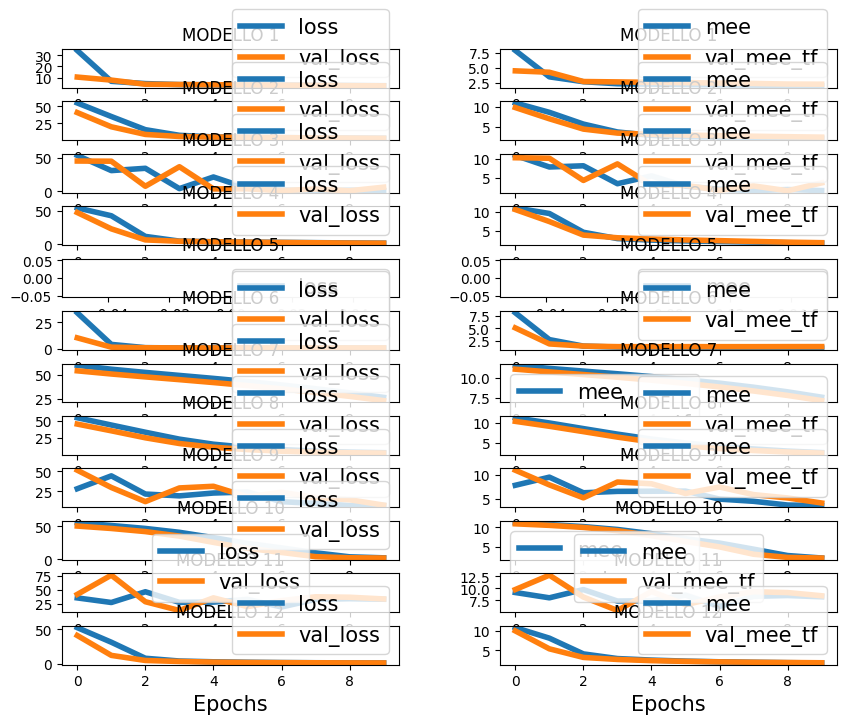

In [16]:
tf.random.set_seed(42)

GS_NN_2 = [
    { # MODELLO 1
        'layers': [
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.03},

    { # MODELLO 2
        'layers': [
            {'units': 16},
            {'units': 8}],
        'learning_rate':0.007},

    { # MODELLO 3
        'layers': [
            {'units': 32},
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.03},

    { # MODELLO 4
        'layers': [
            {'units': 32},
            {'units': 16},
            {'units': 8}],
        'learning_rate': 0.007},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.3},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07},

    { # MODELLO 7
        'layers': [
            {'units': 8}],
        'learning_rate': 0.003},

    { # MODELLO 8
        'layers': [
            {'units': 8}],
        'learning_rate': 0.007},

    { # MODELLO 9
        'layers': [
            {'units': 4},
            {'units': 8}],
        'learning_rate': 0.1},

    { # MODELLO 10
        'layers': [
            {'units': 4},
            {'units': 8}],
        'learning_rate': 0.01},

    { # MODELLO 11
        'layers': [
            {'units': 8},
            {'units': 16}],
        'learning_rate': 0.1},

    { # MODELLO 12
        'layers': [
            {'units': 8},
            {'units': 16}],
        'learning_rate': 0.01},
    ]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_2)

Stavolta i modelli che performano in maniera buona sono 4, 6 e 12.  
Tra questi, il modello che performa meglio è il 6, che sfrutta un solo hidden layer con 8 unità. Proviamo allora a testare ancora di più questo modello, aggiungendo il momenutum e vediamo se un solo layer con più unità performa meglio o peggio.

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.3, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 0.6516, MEE: 1.2892

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.6, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 0.7118, MEE: 1.2621

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.9, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: nan, MEE: nan

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di

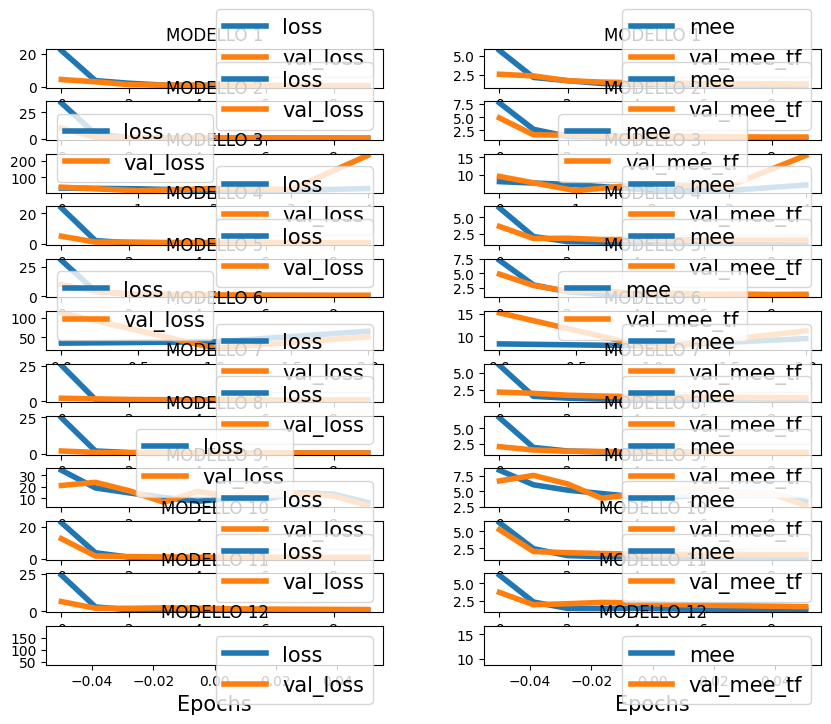

In [17]:
tf.random.set_seed(42)

GS_NN_3 = [
    { # MODELLO 1
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.3},

    { # MODELLO 2
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.6},

    { # MODELLO 3
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.9},

    { # MODELLO 4
        'layers': [
            {'units': 8}],
        'learning_rate': 0.1,
        'momentum': 0.3},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.1,
        'momentum': 0.6},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.1,
        'momentum': 0.9},

    { # MODELLO 7
        'layers': [
            {'units': 16}],
        'learning_rate': 0.07,
        'momentum': 0.3},

    { # MODELLO 8
        'layers': [
            {'units': 16}],
        'learning_rate': 0.07,
        'momentum': 0.6},

    { # MODELLO 9
        'layers': [
            {'units': 16}],
        'learning_rate': 0.07,
        'momentum': 0.9},

    { # MODELLO 10
        'layers': [
            {'units': 16}],
        'learning_rate': 0.1,
        'momentum': 0.3},

    { # MODELLO 11
        'layers': [
            {'units': 16}],
        'learning_rate': 0.1,
        'momentum': 0.6},

    { # MODELLO 12
        'layers': [
            {'units': 16}],
        'learning_rate': 0.1,
        'momentum': 0.9}]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_3)

Un momentum molto alto è evidentemente inutile. I risultati migliori si ottengono per entrambi i modelli quando il learning rate è vicino a 0.07 e il momentum pari o inferiore a 0.6. Inoltre, è interessante notare che utilizzare 8 oppure 16 unità non sembra incidere troppo sulle performance, anzi: mantenendo un momentum più basso, a parità di learning rate, 8 unità generalizzano meglio rispetto a 16. Per questo motivo, e per ridurre il rischio di overfitting, continuiamo la nostra grid search usando 8 unità.

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.3, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 0.6424, MEE: 1.2894

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.15, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 0.974, MEE: 1.4987

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.07, momentum-->0.05, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: 0.6179, MEE: 1.2619

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, nu

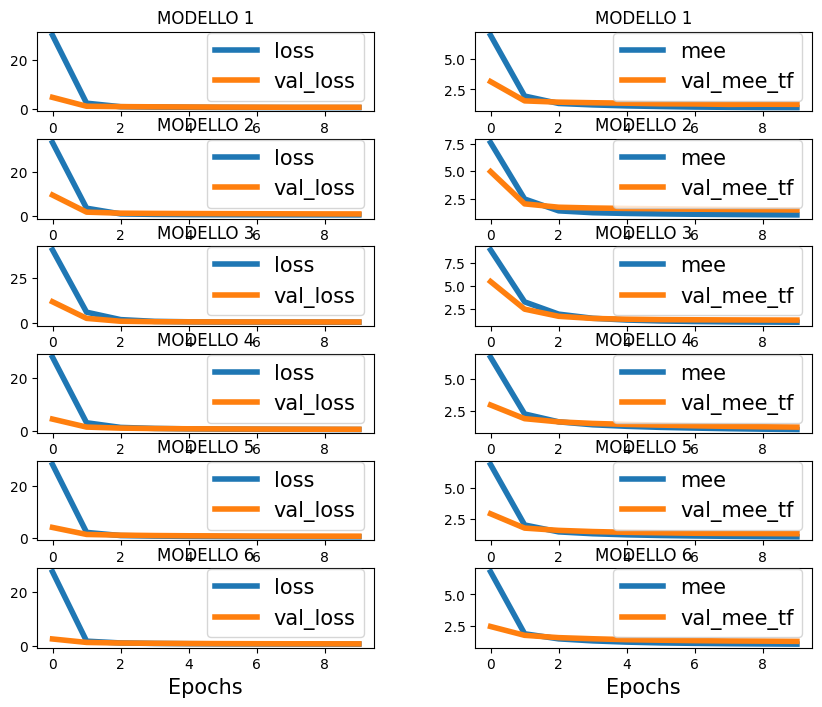

In [18]:
tf.random.set_seed(42)

GS_NN_4 = [
    { # MODELLO 1
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.3},

    { # MODELLO 2
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.15},

    { # MODELLO 3
        'layers': [
            {'units': 8}],
        'learning_rate': 0.07,
        'momentum': 0.05},

    { # MODELLO 4
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.3},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.15},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.05}]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_4)

Abbassare il learning rate funziona soprattutto con momentum più alti. Allora testiamo un ultima gridsearch con quest'idea in mente

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.06, momentum-->0.35, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 0.6965, MEE: 1.3554

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.06, momentum-->0.4, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 0.6194, MEE: 1.228

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.06, momentum-->0.45, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: 0.5953, MEE: 1.2119

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, nu

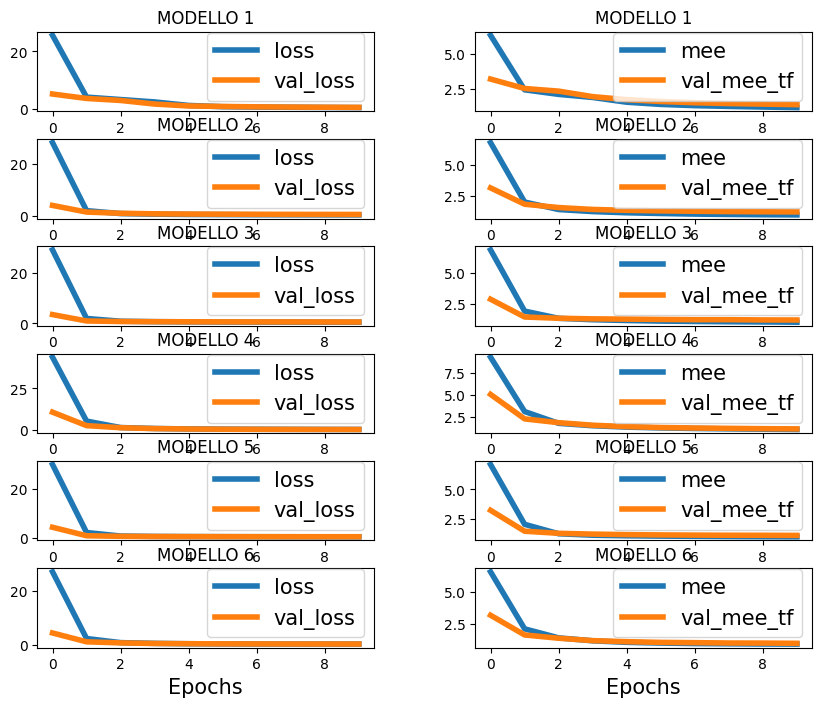

In [19]:
tf.random.set_seed(42)

GS_NN_5 = [
    { # MODELLO 1
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.35},

    { # MODELLO 2
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.4},

    { # MODELLO 3
        'layers': [
            {'units': 8}],
        'learning_rate': 0.06,
        'momentum': 0.45},

    { # MODELLO 4
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.4},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.45},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.5}]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_5)

Il pattern è chiaro: va portato alla sua massima estensione per vedere quando inverte la sua tendenza

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.05, momentum-->0.55, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 1 addestrato! Loss: 0.5254, MEE: 1.1211

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.05, momentum-->0.6, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 2 addestrato! Loss: 0.4738, MEE: 1.0686

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.05, momentum-->0.65, nesterov-->False
Parametri dell'addestramento: epochs-->10, batch_size-->32
MODELLO 3 addestrato! Loss: 0.4459, MEE: 1.0118

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, n

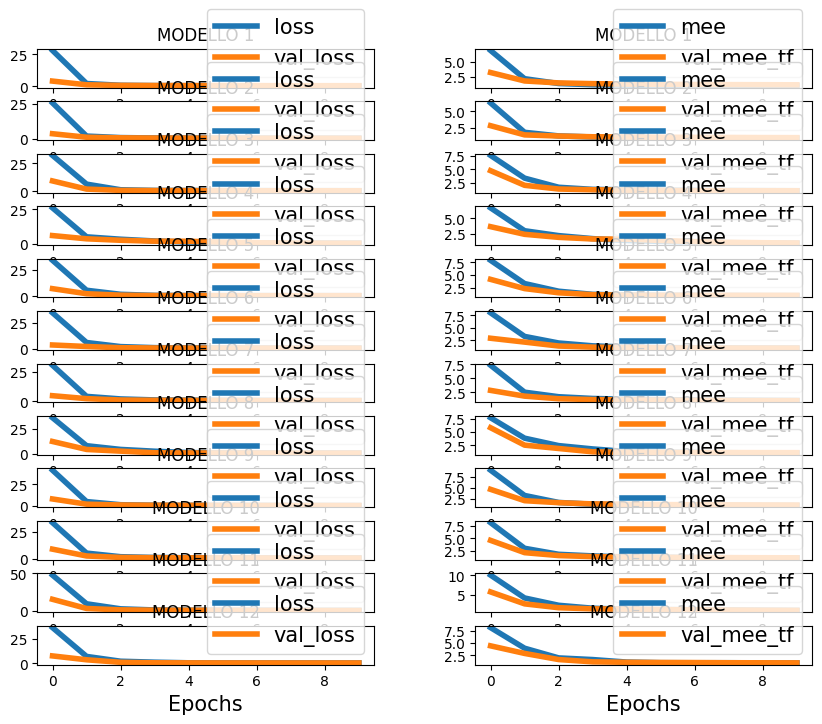

In [20]:
tf.random.set_seed(42)

GS_NN_6 = [
    { # MODELLO 1
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.55},

    { # MODELLO 2
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.6},

    { # MODELLO 3
        'layers': [
            {'units': 8}],
        'learning_rate': 0.05,
        'momentum': 0.65},

    { # MODELLO 4
        'layers': [
            {'units': 8}],
        'learning_rate': 0.04,
        'momentum': 0.6},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.04,
        'momentum': 0.65},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.04,
        'momentum': 0.7},

    { # MODELLO 7
        'layers': [
            {'units': 8}],
        'learning_rate': 0.03,
        'momentum': 0.55},

    { # MODELLO 8
        'layers': [
            {'units': 8}],
        'learning_rate': 0.03,
        'momentum': 0.7},

    { # MODELLO 9
        'layers': [
            {'units': 8}],
        'learning_rate': 0.03,
        'momentum': 0.75},

    { # MODELLO 10
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.7},

    { # MODELLO 11
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.75},

    { # MODELLO 12
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8},
    ]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_6)

Il pattern sembrava essersi interrotto spostando il learning rate a 0.03, ma con learning rate pari a 0.02 e momentum pari a 0.8 raggiungiamo i valori di loss minimi raggiunti finora. Allora teniamo questi valori e proviamo diversi numeri di epoche e di batch size per vedere quali ottengono i risultati migliori.

MODELLO 1
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.02, momentum-->0.8, nesterov-->False
Parametri dell'addestramento: epochs-->20, batch_size-->25
MODELLO 1 addestrato! Loss: 0.3686, MEE: 0.87

MODELLO 2
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.02, momentum-->0.8, nesterov-->False
Parametri dell'addestramento: epochs-->20, batch_size-->50
MODELLO 2 addestrato! Loss: 0.4578, MEE: 1.0268

MODELLO 3
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numero di hidden layers-->1
Parametri del modello: optimizer-->SGD, learning_rate-->0.02, momentum-->0.8, nesterov-->False
Parametri dell'addestramento: epochs-->30, batch_size-->25
MODELLO 3 addestrato! Loss: 0.3562, MEE: 0.8778

MODELLO 4
Parametri dei layers: kernel-->glorot_uniform, activation-->relu, numer

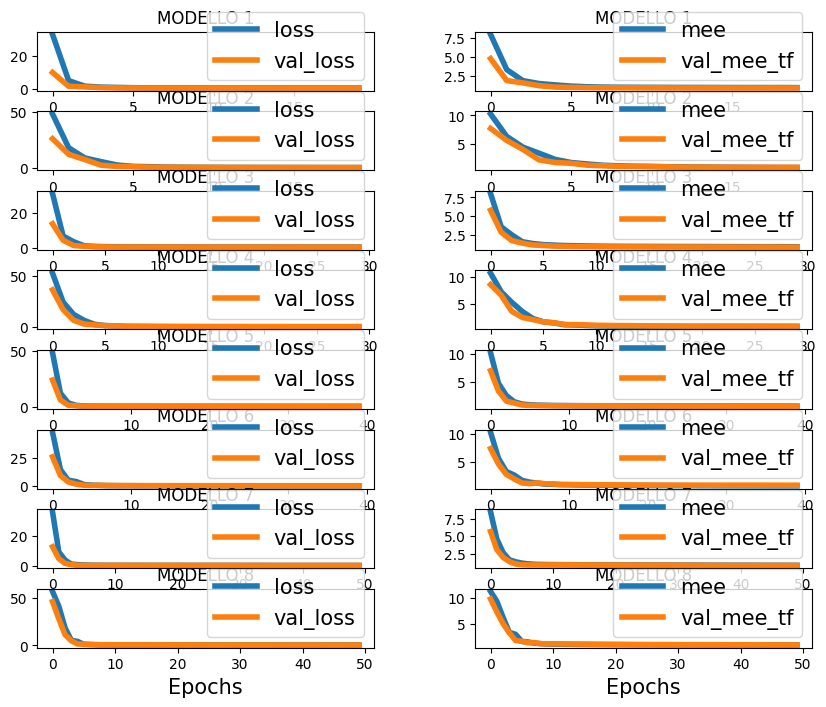

In [21]:
tf.random.set_seed(42)

GS_NN_7 = [
    { # MODELLO 1
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 20,
        'batch_size': 25},

    { # MODELLO 2
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 20,
        'batch_size': 50},

    { # MODELLO 3
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 30,
        'batch_size': 25},

    { # MODELLO 4
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 30,
        'batch_size': 50},

    { # MODELLO 5
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 40,
        'batch_size': 25},

    { # MODELLO 6
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 40,
        'batch_size': 50},

    { # MODELLO 7
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 50,
        'batch_size': 25},

    { # MODELLO 8
        'layers': [
            {'units': 8}],
        'learning_rate': 0.02,
        'momentum': 0.8,
        'epochs': 50,
        'batch_size': 50},
    ]

grid_search_NN(X_train_scaled, y_train, models=GS_NN_7)

Il batch size migliore è 25, il miglior numero di epoche è 40. Allora proviamo a costruire il modello finale proprio con questi parametri.

Modello addestrato! Loss: 0.3341, MEE: 0.8058



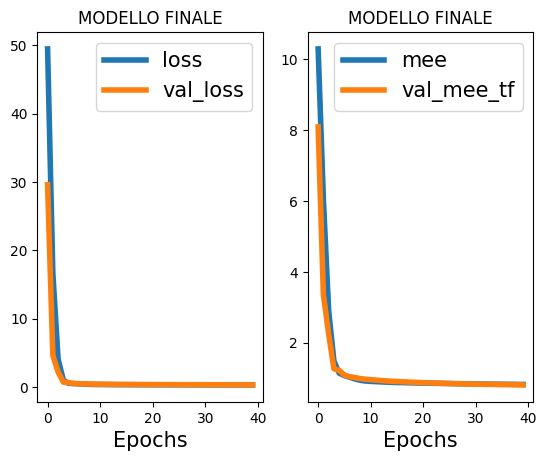

In [27]:
inputs = tf.keras.Input(shape=(12,))
h = tf.keras.layers.Dense(units=8, activation='relu', kernel_initializer='glorot_uniform')(inputs)
outputs = tf.keras.layers.Dense(units=3, kernel_initializer='glorot_uniform')(h)

# inizializzo il modello
MODELLO_FINALE = tf.keras.Model(inputs=inputs, outputs=outputs)

# eseguo il compiling del modello
MODELLO_FINALE.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.02,
                                      momentum=0.8),
    loss='mse',
    metrics=[mee_tf]
)

hist = MODELLO_FINALE.fit(
    X_train_scaled, y_train,
    epochs=40, batch_size=25,
    verbose=0, shuffle=True, validation_split=0.2)

history = hist.history

last_loss = history['val_loss'][-1]
last_mee = history['val_mee_tf'][-1]
print(f'Modello addestrato! Loss: {np.round(last_loss, 4)}, MEE: {np.round(last_mee, 4)}\n')

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['loss', 'val_loss'], fontsize=15)
ax.set_xlabel('Epochs', fontsize=15)
plt.title('MODELLO FINALE')

ax = fig.add_subplot(1, 2, 2)
plt.plot(history['mee_tf'], lw=4)
plt.plot(history['val_mee_tf'], lw=4)
plt.legend(['mee', 'val_mee_tf'], fontsize=15)
ax.set_xlabel('Epochs', fontsize=15)
plt.title('MODELLO FINALE')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


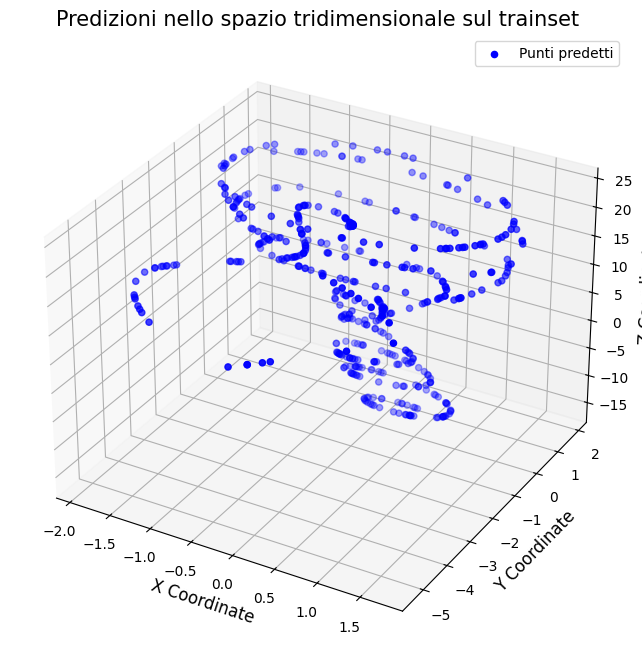

In [28]:
test_predictions = MODELLO_FINALE.predict(X_test_scaled)

x_coords = test_predictions[:, 0]
y_coords = test_predictions[:, 1]
z_coords = test_predictions[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Punti predetti')
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_zlabel('Z Coordinate', fontsize=12)
ax.set_title('Predizioni nello spazio tridimensionale sul trainset', fontsize=15)
ax.legend()

plt.show()